# HR Diagram of M5 Cluster
by Michael Chenevey

## TODO:
- ~~Flat, bias all images~~
- ~~Redo Workshop 4~~
- ~~Abstract mag to a function~~
- ~~Find easy way to box a bunch of stars~~
- Find rects separately from taking mags, we need the same boxes for different filters
- Filter out saturated stars
- Box and mag each star in each filter, calculate temp for each
- Graph HR Diagram for collected stars

## Photometry
We use the astropy package to handle to fits images and as a helper with statistics

In [35]:
# Import astropy packages
import astropy.stats as astats
from astropy.io import fits
import numpy as np
from numpy import nan
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 10,8
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12

from astropy.stats import sigma_clipped_stats
from photutils import find_peaks
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

from photutils import aperture_photometry, CircularAperture
from astropy.modeling import models, fitting

fits_dict = {
    '2sV'   : 'fbt_0138.M67.fits',
    '5sV'   : 'fbt_0137.M67.fits',
    '30sV'  : 'fbt_0139.M67.fits',
    '120sV' : 'fbt_0140.M67.fits',
    '300sV' : 'fbt_0141.M67.fits',
    '2sB'   : 'fbt_0143.M67.fits',
    '5sB'   : 'fbt_0142.M67.fits',
    '30sB'  : 'fbt_0144.M67.fits',
    '120sB' : 'fbt_0145.M67.fits',
    '300sB' : 'fbt_0146.M67.fits',
    '5sR'   : 'fbt_0147.M67.fits',
    '30sR'  : 'fbt_0148.M67.fits',
    '120sR' : 'fbt_0149.M67.fits',
    '300sR' : 'fbt_0150.M67.fits'
}

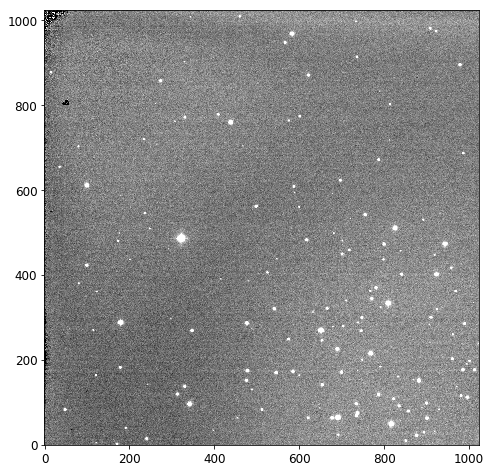

In [36]:
# Open an image
filename = fits_dict['5sB']
hdulist  = fits.open(filename)

imlist  = hdulist[1:]

scidata = imlist[1].data

# Calculate the mean, median, and standard deviation of the data in the image.
mean, median, std = astats.sigma_clipped_stats(scidata, sigma=3.0, maxiters=5)

# Plot the image
plt.figure(figsize=(10,8)) 
plt.imshow(scidata, vmin=median-6.0*std, vmax=median+6.0*std, cmap='gray', origin='lower')
plt.show()



x_peak y_peak peak_value
------ ------ ----------
   172      2  415.99667
   123      5  158.00835
   851     10   390.7572
   241     15  1225.0588
   877     23  1038.2407
   692     24  418.31653
   894     30  313.80893
   919     32  168.96996
   398     35  157.16588
   192     40  448.48315


(0, 1023)

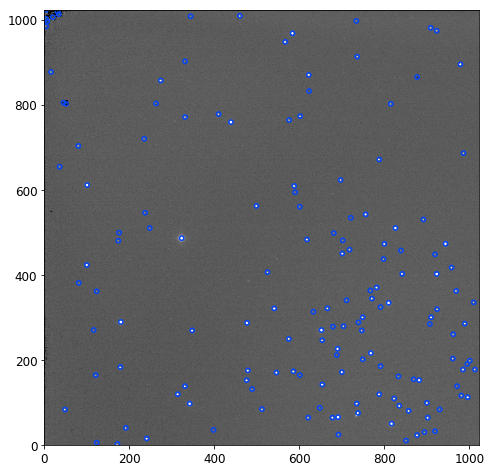

In [37]:

mean, median, std = sigma_clipped_stats(scidata, sigma=3.0)
threshold = median + (10. * std)
tbl = find_peaks(scidata, threshold, box_size=11)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output

print(tbl[:10])    # print only the first 10 peaks

positions = (tbl['x_peak'], tbl['y_peak'])

def get_rect(x, y):
    return (max(0, x - 10), max(0, y - 10), x + 10, y + 10)

rects = [get_rect(positions[0][i], positions[1][i]) for i in range(len(positions[0]))]
apertures = CircularAperture(positions, r=5.)
norm = simple_norm(scidata, 'sqrt', percent=99.9)
plt.imshow(scidata, cmap='Greys_r', origin='lower', norm=norm)
apertures.plot(color='#0547f9', lw=1.5)
plt.xlim(0, scidata.shape[1]-1)
plt.ylim(0, scidata.shape[0]-1)

We can do a test on one of our stars now:

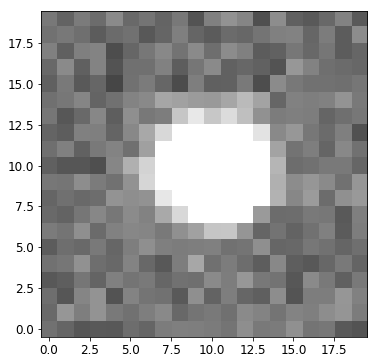

In [38]:
rect = rects[31]

# Crop the Array
cropped_data = scidata[rect[1]:rect[3],rect[0]:rect[2]]

# Plot the Data
plt.figure(figsize=(6,6)) 
plt.imshow(cropped_data, vmin=median-6.0*std, vmax=median+6.0*std, cmap='gray', origin='lower')
plt.show()

### From Workshop 4

"Stars on an image have what is called a Point Spread Function, which is, simply put, a function of how the photons spread over the image. A gaussian is a reasonable function that describes a star's PSF. Now, just like we fit a gaussian function before to the spectroscopic line, we're going to fit a 2D gaussian to the star.

In this case you don't have to define a 2D gaussian, one is already provided for you in the astropy package. We're going to import this model as well as a function that can fit these models. Since the image also has a background, we are going to need a compound model that combined a 2D Gaussian plus a constant background.

Based on the image above, we can fill in the missing parameters for initial guess for the model."

In [39]:
# Construct the Model
starmodel = models.Gaussian2D(amplitude=10000.0, x_mean=10.0, y_mean=10.0, x_stddev=1.0, y_stddev=1.0)
const     = models.Const2D(amplitude=20000.0)
fullmodel = starmodel + const

# We need a grid over which to fit the model
y, x = np.mgrid[:20, :20]

# Fit the data
fitter = fitting.LevMarLSQFitter()

# Print Results
bestfit = fitter(fullmodel, x, y, cropped_data)

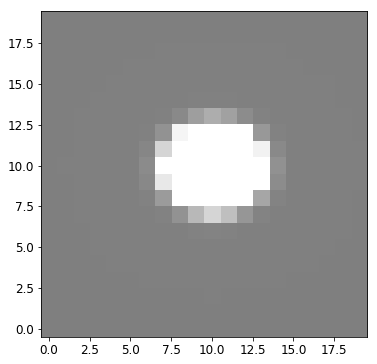

In [40]:
# Evaluate the best model
resulting_model = bestfit(x,y)

# Get the median
_, median_model, _ = astats.sigma_clipped_stats(resulting_model, sigma=3.0, maxiters=5)

plt.figure(figsize=(6,6))
plt.imshow(bestfit(x,y), vmin=median_model-6.0*std, vmax=median_model+6.0*std, cmap='gray', interpolation='none', origin='lower')
plt.show()

(321, 128, 341, 148)
331.0707743600468 137.88925756697242 6.505800465161634


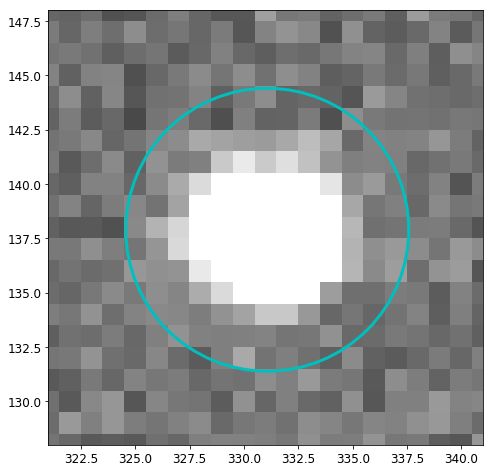

 id      xcenter           ycenter          aperture_sum   
           pix               pix                           
--- ----------------- ------------------ ------------------
  1 331.0707743600468 137.88925756697242 22755.445118200347


In [41]:
sigma = (bestfit.x_stddev_0.value + bestfit.y_stddev_0.value) / 2
FWHM = (2 * (2 * np.log(2)) ** (1/2)) * sigma
scale = 0.774
seeing = FWHM * scale

print(rect)
xcenter       = rect[0] + bestfit.x_mean_0.value
ycenter       = rect[1] + bestfit.y_mean_0.value
aperture_size = 2.5 * FWHM
print(xcenter, ycenter, aperture_size)

# Define an Aperture
position = (xcenter, ycenter)
aperture = CircularAperture(position, r=aperture_size)

# Plot the aperture
plt.figure(figsize=(8,8))
plt.imshow(scidata, vmin=median_model-6.0*std, vmax=median_model+6.0*std, cmap='gray', interpolation='none')
aperture.plot(color='c', lw=3)

#zoom in on region where star is 
plt.xlim(rect[0],rect[2])
plt.ylim(rect[1],rect[3])
plt.show()

result = aperture_photometry(scidata, aperture)
print(result)

### Again, from Workshop 4: ###

Now that we know how many counts there are in the aperture, we can figure out the magnitude of the star.

We can use the documentation of IRAF's `phot` function to figure out how to calculate this. `phot` calculates the magnitude as follows:

$$ flux = sum - area \times msky $$
$$ mag = zmag - 2.5 \times \log(flux) + 2.5 \times \log(itime) $$
$$ error = sqrt\left(\frac{flux}{epadu} + area \times stdev^2 + area^2 \times \frac{stdev^2}{nsky}\right) $$
$$ merr = 1.0857 \times \left(\frac{error}{flux}\right) $$

In these equations, $sum$ is the number of counts inside the aperture, $msky$ is the number of counts per pixel due to the sky, $area$ is the number of pixels in the aperture, $zmag$ is the zero-point (30 is the default), $itime$ is the exposure time, $epadu$ is the gain in electrons per adu, $stdev$ is the standard deviation of the background in counts, and $nsky$ is the number of pixels used for the sky region. 1.0857 is the correction term between an error in flux (electons) and one in magnitudes.

In [42]:
msky = bestfit.amplitude_1.value
zmag = 30
exp_time = hdulist[0].header['EXPTIME']

flux = result['aperture_sum'] - (np.pi * (aperture_size/2) ** 2) * msky
mag = zmag - 2.5 * np.log10(flux) + 2.5 * np.log10(exp_time)

print(mag)

   aperture_sum  
-----------------
21.01676802679737


# Cluster Comprehension
Next, we will abstract our work from Workshop 4 into some usable functions so we can iterate over all of our stars

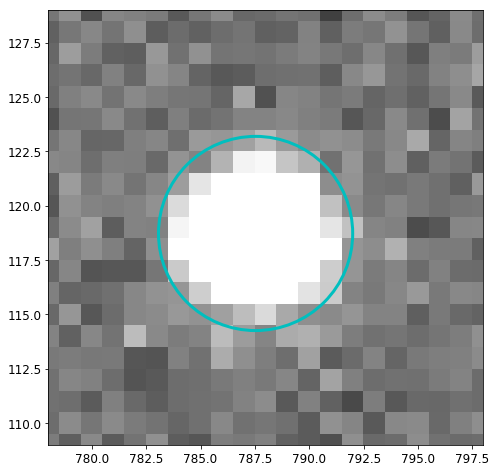

A = 1178.9418097508692
x = 9.531910299857248
y = 9.71904071902779
x_sigma = 1.1294248910992504
y_sigma = 1.1726445454049472
C = 105.38138218734804
(21.283131240567677, <astropy.io.fits.hdu.image.ImageHDU object at 0x1324043198>, (778, 109, 798, 129))


In [93]:
'''
get_mag(img, rect):

Extracts a magnitude, but may return None if the star is determined to be oversaturated
Additionally, we may detect if our aperture incorrectly contains more than 1 star/source.
'''

def get_mag(img, rect, zmag=30, graph=False):
    scidata = img.data
    cropped_data = scidata[rect[1]:rect[3],rect[0]:rect[2]]
    
    # Construct the Model
    starmodel = models.Gaussian2D(amplitude=10000.0, x_mean=10.0, y_mean=10.0, x_stddev=1.0, y_stddev=1.0)
    const     = models.Const2D(amplitude=20000.0)
    fullmodel = starmodel + const

    # We need a grid over which to fit the model
    y, x = np.mgrid[:20, :20]

    try:
        # Fit the data
        fitter          = fitting.LevMarLSQFitter()
        bestfit         = fitter(fullmodel, x, y, cropped_data)
        resulting_model = bestfit(x,y)

        # Get the median
        _, median_model, _ = astats.sigma_clipped_stats(resulting_model, sigma=3.0, maxiters=5)
        sigma  = (bestfit.x_stddev_0.value + bestfit.y_stddev_0.value) / 2
        FWHM   = (2 * (2 * np.log10(2)) ** (1/2)) * sigma
        scale  = 0.774
        seeing = FWHM * scale

        xcenter       = rect[0] + bestfit.x_mean_0.value
        ycenter       = rect[1] + bestfit.y_mean_0.value
        aperture_size = 2.5 * FWHM

        # Define an Aperture
        position = (xcenter, ycenter)
        aperture = CircularAperture(position, r=aperture_size)
        
        if graph:
            # Plot the aperture
            plt.figure(figsize=(8,8))
            plt.imshow(scidata, vmin=median_model-6.0*std, vmax=median_model+6.0*std, cmap='gray', interpolation='none')
            aperture.plot(color='c', lw=3)

            #zoom in on region where star is 
            plt.xlim(rect[0],rect[2])
            plt.ylim(rect[1],rect[3])
            plt.show()
            
            print("A = "       + str(bestfit.amplitude_0.value))
            print("x = "       + str(bestfit.x_mean_0.value   ))
            print("y = "       + str(bestfit.y_mean_0.value   ))
            print("x_sigma = " + str(bestfit.x_stddev_0.value ))
            print("y_sigma = " + str(bestfit.y_stddev_0.value ))
            print("C = "       + str(bestfit.amplitude_1.value))

        if bestfit.x_stddev_0.value <= 0.1 or bestfit.y_stddev_0.value <= 0.1:
            raise Exception('Anomalous Gaussian!')
        elif bestfit.x_stddev_0.value >= 5 or bestfit.y_stddev_0.value >= 5:
            raise Exception('Anomalous Gaussian!')
            
        result   = aperture_photometry(scidata, aperture)
        msky     = bestfit.amplitude_1.value
        zmag     = zmag
        exp_time = 5

        flux = result['aperture_sum'] - (np.pi * (aperture_size/2) ** 2) * msky
        mag  = zmag - 2.5 * np.log10(flux) + 2.5 * np.log10(exp_time)

    except:
        return None

    if mag[0] > zmag or mag[0] < 5:
        return None
    return (mag[0], img, rect)

print(get_mag(imlist[1], rects[29], graph=True))

Next we need to construct a way to handle 4-quadrant images in different filters

In [94]:
# We have a lot of stars, so we can change warnings to exceptions and be selective
import warnings
warnings.simplefilter('error', UserWarning)
np.seterr(all='raise')

# Our stars should be in the same positions across filters
def get_rects(img):
    scidata = img.data
    # Calculate the mean, median, and standard deviation of the data in the image.
    mean, median, std = astats.sigma_clipped_stats(scidata, sigma=3.0, maxiters=5)
    threshold = median + (5. * std)
    tbl = find_peaks(scidata, threshold, box_size=11)
    tbl['peak_value'].info.format = '%.8g'  # for consistent table output
    positions = (tbl['x_peak'], tbl['y_peak'])

    def get_rect(x, y):
        return (max(0, x - 10), max(0, y - 10), x + 10, y + 10)

    rects = [get_rect(positions[0][i], positions[1][i]) for i in range(len(positions[0]))]
    return rects

def get_mags(img, rects, zmag=30):
    mags = [get_mag(img, rects[i], zmag) for i in range(len(rects))]
    return mags
    
def get_mags_from_filters(fits_lst):
    imlists = []
    for file in fits_lst:
        hdulist  = fits.open(file[0])
        imlist  = hdulist[1:]
        # Append list of images paired with zmag for the file
        imlists.append((imlist, file[1]))
    
    # Contains a list of magnitudes for each filter across all frames
    mags = [[] for i in range(len(fits_lst))]
    
    for frame in range(len(imlists[0])):
        # Get star locations for frame i
        # rects = get_rects(imlists[0][0][0])
        
        # Loop over all filters of current frame and get mags
        for filt in range(len(imlists)):
            rects = get_rects(imlists[filt][0][frame])
            mags_frame = get_mags(imlists[filt][0][frame], rects, zmag=imlists[filt][1])
            mags[filt].extend(mags_frame)
    return mags

Now, we can construct an HR graph using the difference between the V and B magnitudes as color and the V magnitude as the luminosity

In [111]:
# Pull magnitudes from a list of exposures
mags_lst = get_mags_from_filters([(fits_dict['5sV'], 30), (fits_dict['5sB'], 30)])

In [112]:
# Characterize mags
print(mags_lst[0][4])

(20.69098001398622, <astropy.io.fits.hdu.image.ImageHDU object at 0x1324fec8d0>, (550, 5, 570, 25))


In [113]:
def app_to_abs(mag, d=827.8):
    return mag - 5.0 * np.log10(d/10)

def absmag_to_luminosity(mag):
    return 10.0 ** ((4.83 - mag) / 2.5)

def appmag_to_luminosity(mag, d=827.8):
    return absmag_to_luminosity(app_to_abs(mag, d=d))

[(12.277122883864918, 12.510843634148811), (12.001403776984676, 12.108626967235265), (13.120874549310885, 12.244363469086844), (12.555770195752997, 12.964744485085737), (12.751879368318706, 12.428650952327805), (12.061816343183713, 12.455029004962357), (12.121758860461503, 13.075728921604979), (12.7190896516352, 12.990799299115826), (12.70925195244242, 12.363441663077415), (11.965082844991704, 12.629640031959445), (12.783217655964767, 13.225598998004683), (12.731274832825582, 13.14131458435652), (11.976641549115753, 12.732199059485003), (12.757995901373382, 12.19288087227041), (12.39060401926326, 12.884448463783647), (13.089381652632524, 11.904848366377918), (12.669881375175583, 12.093842936571837), (12.890688799248798, 12.683744768451314), (11.805719729188992, 12.08231036385301), (12.57882052547559, 12.4558492481962), (11.403159550559971, 13.07103580367667), (11.682512853048367, 12.56995577878637), (12.31418461582903, 11.685275220679495), (12.200559277790068, 13.3737458753218), (12.52

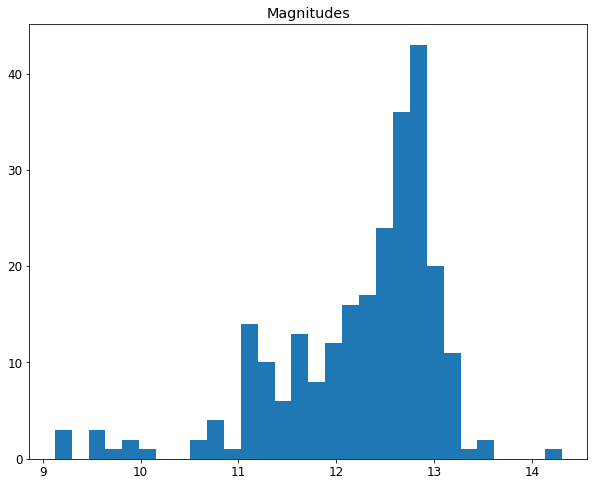

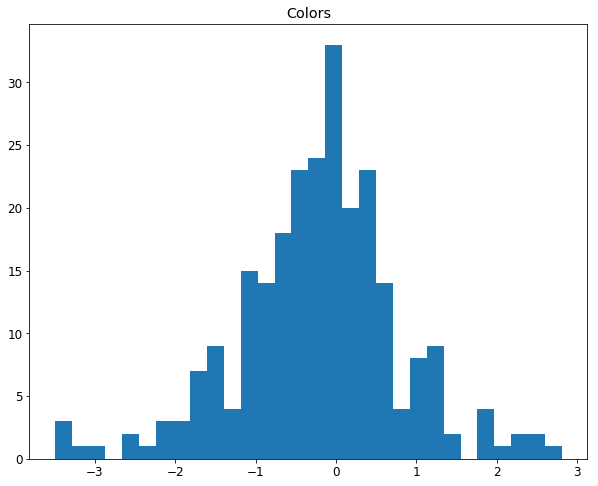

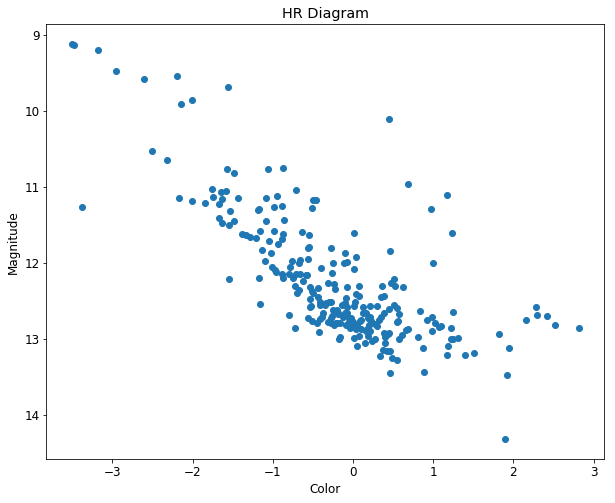

In [115]:
# Remove any stars that are missing values
cleaned_mags = list(zip(*mags_lst))
cleaned_mags = [(app_to_abs(x[0][0]), app_to_abs(x[1][0])) for x in cleaned_mags if None not in x]

def ballesteros(B_V):
    return 4600 * (1 / (0.92 * B_V + 1.7) + 1 / (0.92 * B_V + 1.62)) 

# Get the values for the axes in our scatterplot
luminosities = [x[0] for x in cleaned_mags]
colors = [x[0] - x[1] for x in cleaned_mags]
print(cleaned_mags)

plt.title("Magnitudes")
plt.hist(luminosities, bins=30)
plt.show()
plt.title("Colors")
plt.hist(colors, bins=30)
plt.show()

plt.title("HR Diagram")
plt.xlabel("Color")
plt.ylabel("Magnitude")
plt.scatter(colors, luminosities)
plt.gca().invert_yaxis()
plt.show()

# Testing/Debugging

In [69]:
cmags = list(zip(*mags_lst))
cmags = [(x[0][0], x[1][0]) if not None in x else (0, 0) for x in cmags]
n_colors = [x[0] - x[1] for x in cmags]
print(np.argmax(n_colors))


351


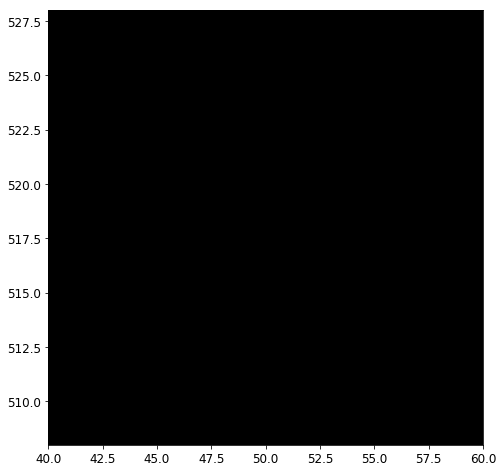

Shown mag: 22.81046501699594 for rect 40-60, 508-528


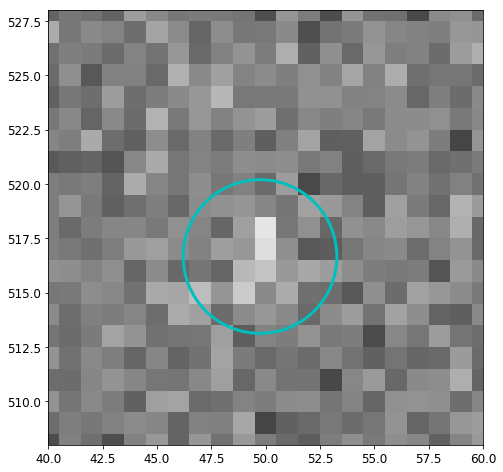

A = 28.81632972689833
x = 9.741721127421242
y = 8.658476804944607
x_sigma = 1.1670596525598393
y_sigma = 0.6546540494539849
C = 121.63421653671378
(22.81046501699594, <astropy.io.fits.hdu.image.ImageHDU object at 0x1324a10940>, (40, 508, 60, 528))


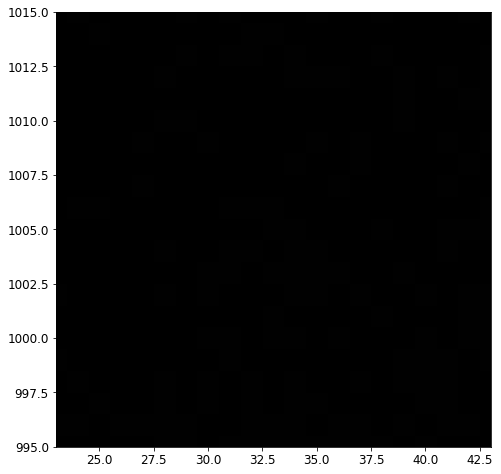

Shown mag: 17.531477504304238 for rect 23-43, 995-1015


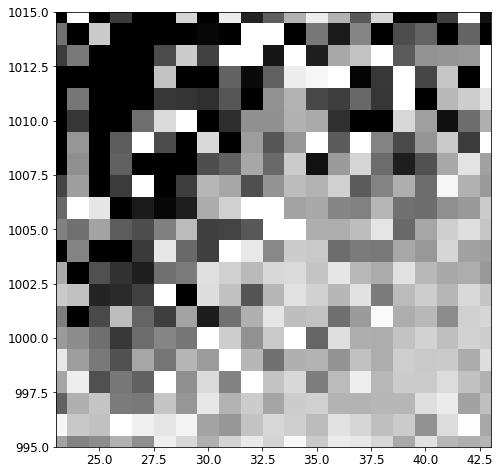

A = 80.97698790021289
x = 13.971666011127304
y = 0.4813877457935945
x_sigma = 13.542549023216871
y_sigma = 12.708890729747699
C = 24.022694318555953
(17.531477504304238, <astropy.io.fits.hdu.image.ImageHDU object at 0x1325100748>, (23, 995, 43, 1015))


In [70]:
# Plot a sample aperture
sample = 351

try:
    for i, mags_filter in enumerate(mags_lst):
        img = mags_filter[sample][1]
        rect = mags_lst[i][sample][2]

        # Plot image
        plt.figure(figsize=(8,8))
        plt.imshow(img.data, cmap='gray', interpolation='none')
        aperture.plot(color='c', lw=3)

        # Zoom in on region where star is 
        plt.xlim(rect[0],rect[2])
        plt.ylim(rect[1],rect[3])
        plt.show()

        print("Shown mag: {} for rect {}-{}, {}-{}".format(mags_filter[sample][0], rect[0], rect[2], rect[1], rect[3]))
        print(get_mag(img, rect, zmag=30, graph=True))
except:
    print("sample {} invalid and mag calculation cannot be displayed".format(sample))
    
    
    

In [ ]:
colors = [x[1] - x[0] for x in cleaned_mags]